In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
import os
import glob
import matplotlib.pyplot as plt

from pathlib import PurePath
from sklearn import metrics as skmetrics
from sklearn import dummy as skdummy
from IPython import display

import vxs
import vxs.utils as vxsu

In [2]:
avp_set = vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset/')

In [3]:
def compare_fixed_personal(name):
    fixed = name + '_Fixed'
    personal = name + '_Personal'
    for x in [fixed, personal]:
        track, anno = avp_set.get(x)
        vxsu.display_track(track)

../data/avp-dataset/AVP_Dataset/Fixed/Participant_5/P5_HHclosed_Fixed.wav


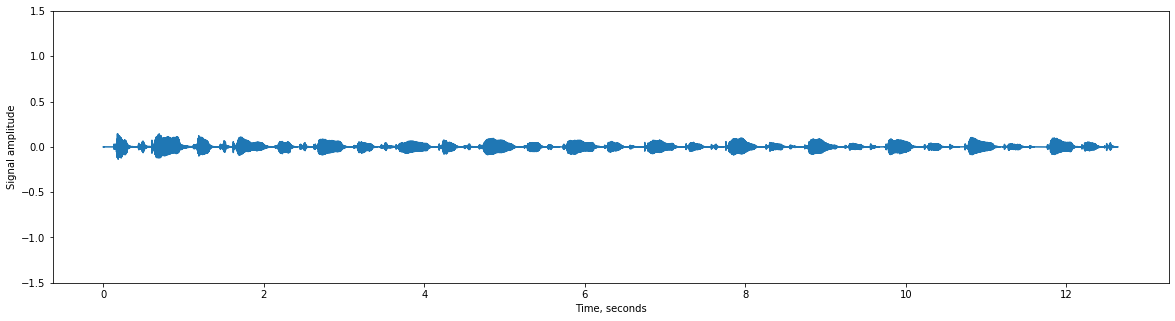

../data/avp-dataset/AVP_Dataset/Personal/Participant_5/P5_HHclosed_Personal.wav


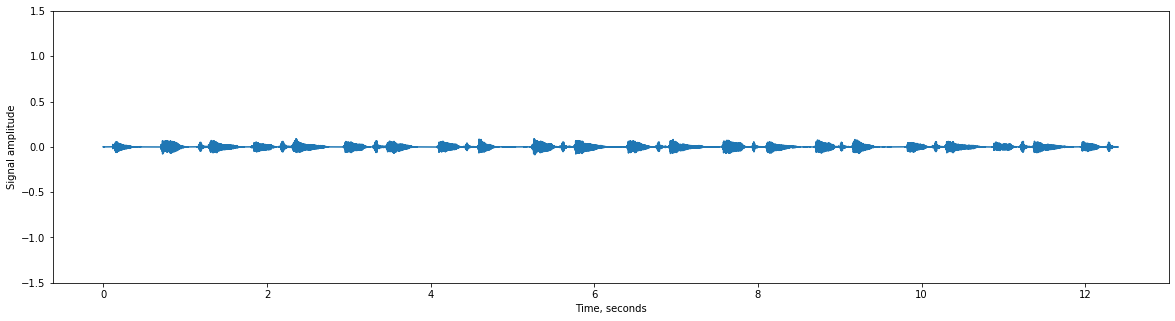

In [4]:
compare_fixed_personal('P5_HHclosed')

In [5]:
gen_set2 = vxs.GenTrackSet('../data_temp/beatboxset1-gen/')

../data_temp/beatboxset1-gen/beatboxset1_bui_5.wav


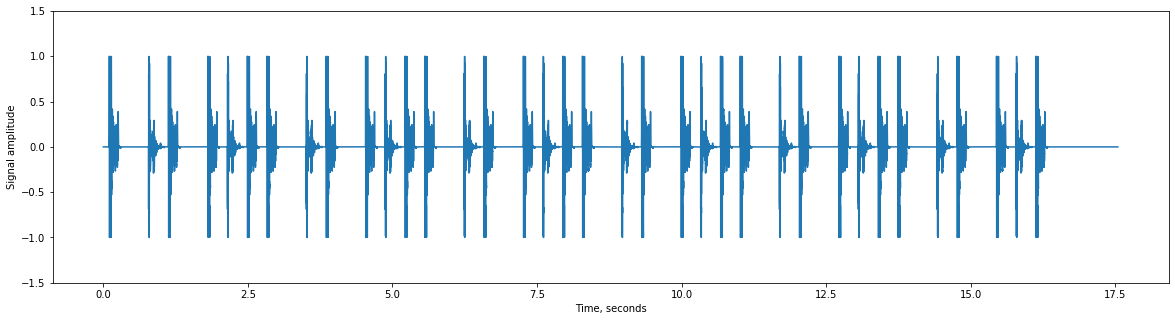

In [6]:
tr, an = gen_set2.get(49)
vxsu.display_track(tr)

### Generated stuff

In [7]:
gen_set = vxs.GenTrackSet('../data_temp/avp-gen/')
len(gen_set)

50

../data_temp/avp-gen/avp_p4_fixed_7.wav


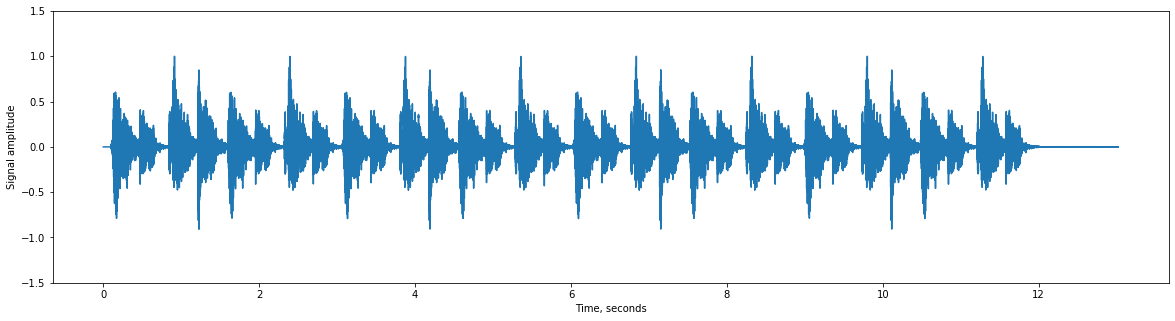

In [8]:
track, anno = gen_set.get(5)
vxsu.display_track(track)

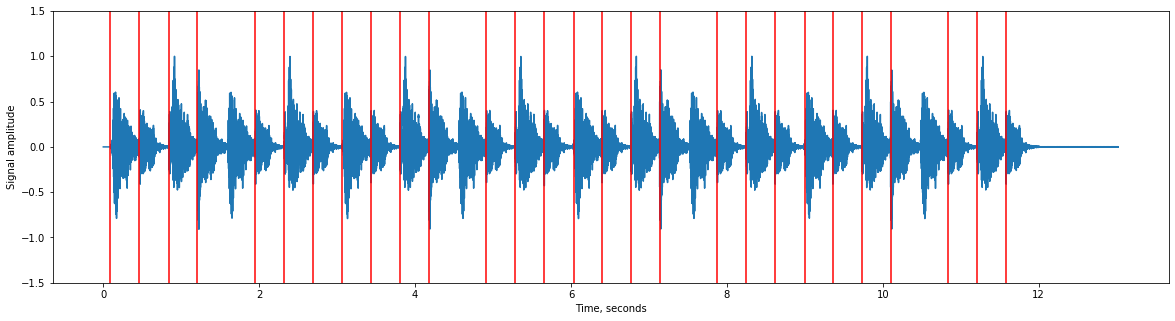

In [9]:
onsets = vxs.detect_onsets(track, method='complex')
vxsu.plot_track(track, onsets=onsets)

In [105]:
titles_map_metric = {
    'prec': 'Precision',
    'rec': 'Recall',
    'F1': 'F1'
}

titles_map_classes = {
    'kd': 'Kick',
    'sd': 'Snare',
    'hhc': 'HHClosed',
    'hho': 'HHOpened',
    'mean': 'Mean'
}

def plot_metrics(series_lm, series_nolm, metric, cl,
                 title=None, xlabel=None, ylabel=None, ax=None,
                 ylims=None, legend=False, fsize=14):
    if ax is not None:
        plt.sca(ax)
    plt.plot(series_nolm['keys'], series_nolm[metric][cl], label='No LM')
    plt.plot(series_lm['keys'], series_lm[metric][cl], label='LM')
    plt.xticks(series_lm['keys'], fontsize=fsize-4)
    
    yticks_min = min(np.min(series_nolm[metric][cl]), np.min(series_lm[metric][cl]))
    yticks_max = max(np.max(series_nolm[metric][cl]), np.max(series_lm[metric][cl]))
    yticks = np.linspace(yticks_min-0.005, yticks_max+0.005, 5)
    yticks_labels = [np.format_float_positional(t, precision=2) for t in yticks]
    plt.yticks(ticks=yticks, labels=yticks_labels, fontsize=fsize-4)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=fsize)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=fsize)
    if ylims is not None:
        plt.ylim(ylims)
    if title is not None:
        plt.title(title, fontsize=fsize)
    if legend:
        plt.legend(fontsize=fsize, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(which='both')
    
def plot_all_metrics(series_lm, series_nolm, ylims=None, save_name=None):
    classes = ['kd', 'sd', 'hhc', 'hho', 'mean']
    metrics = ['prec', 'rec', 'F1']

    rows = len(classes)
    cols = len(metrics)
    fig, axes = plt.subplots(ncols=cols, nrows=rows,
                             figsize=(cols*3, rows*1.4),
                             sharex=True, sharey=False)
    for cl_ix, axes_ in enumerate(axes):
        for m_ix, ax in enumerate(axes_):
            cl = classes[cl_ix]
            mc = metrics[m_ix]
            
            title = titles_map_metric[mc] if cl_ix == 0 else None
            ylabel = titles_map_classes[cl] if m_ix == 0 else None
            xlabel = '% of dataset' if cl_ix == len(classes) - 1 else None
            has_legend = cl_ix == len(classes) // 2 and m_ix == len(metrics) - 1
            
            plot_metrics(series_lm, series_nolm, mc, cl,
                         ax=ax, ylims=ylims, title=title, xlabel=xlabel,
                         ylabel=ylabel, legend=has_legend)
        
    fig.tight_layout()
    if save_name is not None:
        vxsu.save_plot(save_name)
    plt.show()

In [10]:
paths = glob.glob('../data_temp/avp-cut/fixed/*/*.wav')
excluded_ps = [f'participant_{n}' for n in range(1, 6)]
paths = [p for p in paths if PurePath(p).parts[-2] not in excluded_ps]

avp_segments_fixed_p6_28 = vxs.SimpleSampleSet(paths)
len(avp_segments_fixed_p6_28)

2765

In [11]:
lang_model = vxs.load_model_from_bundle('../data/drum_kit_rnn.mag')

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from /tmp/tmppjj_lo59/model_drum_kit.ckpt


In [93]:
%%time
evaluation_cfs = vxs.evaluate_with_different_data_sizes(
    avp_segments_fixed_p6_28, gen_set, lang_model,
    model_fn=lambda: vxs.make_knn_classic('mfcc', n_neighbors=15, weights='distance'),
    savedir_pattern='../logs/lm_eval/comparison_lm_mfcc_avpfixed_p{}',
    predefined_bpm=True)

10% of dataset
Classifier training...


Analysing tracks: 0it [00:00, ?it/s]

Evaluating (no LM)


Analysing tracks: 9it [00:01,  4.62it/s]


KeyboardInterrupt: 

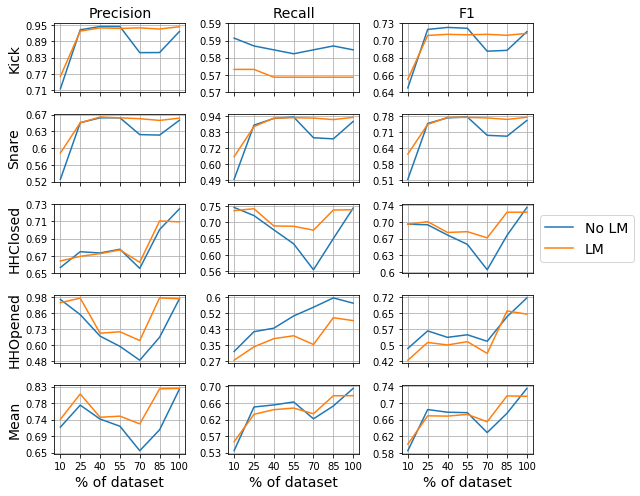

In [106]:
eval_series_nolm = vxs.metrics_series(evaluation_cfs, 'nolm')
eval_series_lm = vxs.metrics_series(evaluation_cfs, 'lm')
plot_all_metrics(eval_series_lm, eval_series_nolm, save_name='lm_nolm_avpfixed_gen')

In [43]:
%%time
evaluation_cfs_noonsets = vxs.evaluate_with_different_data_sizes(
    avp_segments_fixed_p6_28, gen_set, lang_model,
    model_fn=lambda: skdummy.DummyClassifier(), #vxs.make_knn_classic('mfcc', n_neighbors=15, weights='distance'),
    savedir_pattern='../logs/lm_eval/comparison_lm_mfcc_avpfixed_noonsets_p{}',
    predefined_bpm=True, predefined_onsets=True)

/home/ubuntu/Research/msc_dissertation_vpt/vxs-vpt/pythonenv/lib/python3.6/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
Analysing tracks: 0it [00:00, ?it/s]

10% of dataset
Classifier training...
Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.14it/s]


prec       rec        F1
hhc  0.760757  0.839506  0.798194
hho         1  0.346269  0.514412
kd   0.815135         1  0.898154
sd   0.481595  0.405685  0.440393

prec    0.764372
rec     0.647865
F1      0.662788
dtype: float64

Analysing tracks: 0it [00:00, ?it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.25it/s]


prec       rec        F1
hhc  0.758883  0.851852  0.802685
hho  0.980583  0.301493  0.461187
kd   0.844769  0.996021  0.914181
sd   0.566197   0.51938  0.541779

prec    0.787608
rec     0.667186
F1      0.679958
dtype: float64

/home/ubuntu/Research/msc_dissertation_vpt/vxs-vpt/pythonenv/lib/python3.6/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
Analysing tracks: 0it [00:00, ?it/s]

25% of dataset
Classifier training...
Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.24it/s]


prec       rec        F1
hhc  0.751558  0.801519  0.775735
hho  0.741935  0.343284  0.469388
kd   0.949622         1   0.97416
sd   0.630197  0.744186  0.682464

prec    0.768328
rec     0.722247
F1      0.725437
dtype: float64

Analysing tracks: 0it [00:00, ?it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.02it/s]


prec       rec        F1
hhc  0.766178  0.843305  0.802893
hho  0.982906  0.343284   0.50885
kd   0.956743  0.997347  0.976623
sd   0.646681  0.780362   0.70726

prec    0.838127
rec     0.741074
F1      0.748907
dtype: float64

/home/ubuntu/Research/msc_dissertation_vpt/vxs-vpt/pythonenv/lib/python3.6/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
Analysing tracks: 0it [00:00, ?it/s]

40% of dataset
Classifier training...
Evaluating (no LM)


Analysing tracks: 50it [00:10,  4.82it/s]


prec       rec        F1
hhc  0.757407  0.776828  0.766995
hho  0.666667   0.39403   0.49531
kd   0.949622         1   0.97416
sd   0.630197  0.744186  0.682464

prec    0.750973
rec     0.728761
F1      0.729732
dtype: float64

Analysing tracks: 0it [00:00, ?it/s]

Evaluating (LM)


Analysing tracks: 50it [00:10,  4.97it/s]


prec       rec        F1
hhc  0.751575  0.792972  0.771719
hho  0.672727  0.331343     0.444
kd   0.944724  0.997347  0.970323
sd   0.636761  0.751938  0.689573

prec    0.751447
rec     0.718400
F1      0.718904
dtype: float64

/home/ubuntu/Research/msc_dissertation_vpt/vxs-vpt/pythonenv/lib/python3.6/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
Analysing tracks: 0it [00:00, ?it/s]

55% of dataset
Classifier training...
Evaluating (no LM)


Analysing tracks: 50it [00:11,  4.52it/s]


prec       rec        F1
hhc  0.757407  0.776828  0.766995
hho  0.666667   0.39403   0.49531
kd   0.949622         1   0.97416
sd   0.630197  0.744186  0.682464

prec    0.750973
rec     0.728761
F1      0.729732
dtype: float64

Analysing tracks: 0it [00:00, ?it/s]

Evaluating (LM)


Analysing tracks: 50it [00:10,  4.83it/s]


prec       rec        F1
hhc  0.754768  0.789174  0.771588
hho  0.695906  0.355224  0.470356
kd   0.936488  0.997347   0.96596
sd   0.621145  0.728682   0.67063

prec    0.752077
rec     0.717607
F1      0.719633
dtype: float64

/home/ubuntu/Research/msc_dissertation_vpt/vxs-vpt/pythonenv/lib/python3.6/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
Analysing tracks: 0it [00:00, ?it/s]

70% of dataset
Classifier training...
Evaluating (no LM)


Analysing tracks: 50it [00:10,  4.76it/s]


prec       rec        F1
hhc  0.750909  0.784425  0.767301
hho  0.674157  0.358209  0.467836
kd   0.891253         1    0.9425
sd   0.582716  0.609819   0.59596

prec    0.724759
rec     0.688113
F1      0.693399
dtype: float64

Analysing tracks: 0it [00:00, ?it/s]

Evaluating (LM)


Analysing tracks: 50it [00:10,  4.68it/s]


prec       rec        F1
hhc  0.767888  0.835708  0.800364
hho   0.97619  0.367164  0.533623
kd   0.924969  0.997347  0.959796
sd   0.612613  0.702842  0.654633

prec    0.820415
rec     0.725765
F1      0.737104
dtype: float64

/home/ubuntu/Research/msc_dissertation_vpt/vxs-vpt/pythonenv/lib/python3.6/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
Analysing tracks: 0it [00:00, ?it/s]

85% of dataset
Classifier training...
Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.06it/s]


prec       rec        F1
hhc   0.80109  0.837607  0.818942
hho  0.988701  0.522388  0.683594
kd   0.891253         1    0.9425
sd   0.582716  0.609819   0.59596

prec    0.815940
rec     0.742454
F1      0.760249
dtype: float64

Analysing tracks: 0it [00:00, ?it/s]

Evaluating (LM)


Analysing tracks: 50it [00:10,  4.83it/s]


prec       rec        F1
hhc  0.826617  0.837607  0.832075
hho  0.990244   0.60597  0.751852
kd   0.918193  0.997347  0.956135
sd   0.609589  0.689922  0.647273

prec    0.836161
rec     0.782712
F1      0.796834
dtype: float64

/home/ubuntu/Research/msc_dissertation_vpt/vxs-vpt/pythonenv/lib/python3.6/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
Analysing tracks: 0it [00:00, ?it/s]

100% of dataset
Classifier training...
Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.30it/s]


prec       rec        F1
hhc  0.800725  0.839506  0.819657
hho         1  0.519403  0.683694
kd   0.949622         1   0.97416
sd   0.630197  0.744186  0.682464

prec    0.845136
rec     0.775774
F1      0.789994
dtype: float64

Analysing tracks: 0it [00:00, ?it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.30it/s]


prec       rec        F1
hhc  0.823529  0.837607  0.830508
hho  0.989899  0.585075   0.73546
kd   0.948298  0.997347  0.972204
sd   0.633833  0.764858  0.693208

prec    0.848890
rec     0.796222
F1      0.807845
dtype: float64

CPU times: user 2min 19s, sys: 1.69 s, total: 2min 21s
Wall time: 2min 21s


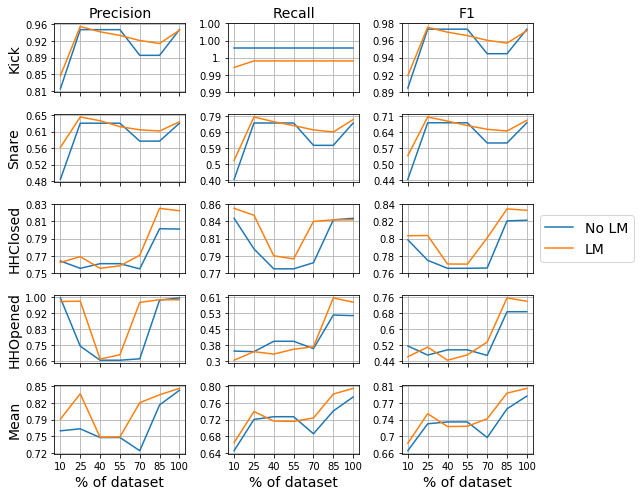

In [114]:
eval_series_noonsets_nolm = vxs.metrics_series(evaluation_cfs_noonsets, 'nolm')
eval_series_noonsets_lm = vxs.metrics_series(evaluation_cfs_noonsets, 'lm')
plot_all_metrics(eval_series_noonsets_lm, eval_series_noonsets_nolm, save_name='lm_nolm_avpfixed_gen_noonsets')

In [45]:
paths = glob.glob('../data_temp/avp-cut/personal/*/*.wav')
excluded_ps = [f'participant_{n}' for n in range(1, 6)]
paths = [p for p in paths if PurePath(p).parts[-2] not in excluded_ps]

avp_segments_personal_p6_28 = vxs.SimpleSampleSet(paths)
len(avp_segments_personal_p6_28)

2317

In [46]:
gen_set_p = vxs.GenTrackSet('../data_temp/avp-gen-personal/')
len(gen_set_p)

50

In [47]:
evaluation_cfs_p = vxs.evaluate_with_different_data_sizes(
    avp_segments_personal_p6_28, gen_set_p, lang_model,
    model_fn=lambda: vxs.make_knn_classic('mfcc', n_neighbors=15, weights='distance'),
    savedir_pattern='../logs/lm_eval/comparison_lm_mfcc_avppersonal_p{}',
    predefined_bpm=True)

10% of dataset
Classifier training...


Analysing tracks: 0it [00:00, ?it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:11,  4.37it/s]


prec        rec         F1
hhc  0.444444  0.0316344  0.0590648
hho  0.139021   0.624113    0.22739
kd   0.540707   0.413146   0.468397
sd   0.152249   0.241096   0.186638

prec    0.319105
rec     0.327497
F1      0.235372
dtype: float64

Analysing tracks: 1it [00:00,  7.77it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.52it/s]


prec        rec        F1
hhc       0.7  0.0799649  0.143533
hho  0.100372   0.382979  0.159057
kd   0.583756    0.40493   0.47817
sd   0.177979   0.323288  0.229572

prec    0.390527
rec     0.297790
F1      0.252583
dtype: float64

25% of dataset
Classifier training...


Analysing tracks: 0it [00:00, ?it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.45it/s]


prec        rec        F1
hhc   0.644628  0.0685413  0.123908
hho  0.0745543   0.326241  0.121372
kd     0.48996   0.286385  0.361481
sd    0.182461   0.353425  0.240672

prec    0.347901
rec     0.258648
F1      0.211858
dtype: float64

Analysing tracks: 1it [00:00,  7.26it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.55it/s]


prec       rec        F1
hhc   0.786127  0.119508  0.207475
hho  0.0646259  0.269504  0.104252
kd    0.518812  0.307512  0.386146
sd    0.204268  0.367123  0.262488

prec    0.393458
rec     0.265912
F1      0.240090
dtype: float64

40% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.20it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.12it/s]


prec       rec        F1
hhc  0.778443  0.114236  0.199234
hho  0.077381  0.276596   0.12093
kd   0.492929  0.286385  0.362287
sd   0.166023  0.353425  0.225919

prec    0.378694
rec     0.257660
F1      0.227092
dtype: float64

Analysing tracks: 1it [00:00,  7.85it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.47it/s]


prec       rec        F1
hhc   0.917582  0.146749   0.25303
hho  0.0994152  0.241135  0.140787
kd         0.5  0.287559  0.365127
sd     0.14978  0.372603  0.213668

prec    0.416694
rec     0.262011
F1      0.243153
dtype: float64

55% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.20it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:10,  4.98it/s]


prec       rec        F1
hhc   0.783019  0.072935  0.133441
hho  0.0821355  0.283688  0.127389
kd    0.492929  0.286385  0.362287
sd    0.150877  0.353425  0.211475

prec    0.377240
rec     0.249108
F1      0.208648
dtype: float64

Analysing tracks: 1it [00:00,  8.13it/s]

Evaluating (LM)


Analysing tracks: 50it [00:08,  5.59it/s]


prec       rec        F1
hhc   0.97561  0.140598  0.245776
hho  0.183333  0.312057  0.230971
kd   0.493952  0.287559  0.363501
sd   0.123288  0.345205  0.181687

prec    0.444046
rec     0.271355
F1      0.255484
dtype: float64

70% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.22it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.23it/s]


prec       rec        F1
hhc  0.862245  0.148506  0.253373
hho  0.103352  0.262411  0.148297
kd   0.492929  0.286385  0.362287
sd   0.144295  0.353425  0.204925

prec    0.400705
rec     0.262682
F1      0.242220
dtype: float64

Analysing tracks: 1it [00:00,  7.61it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.17it/s]


prec       rec        F1
hhc  0.856459  0.157293  0.265776
hho  0.159836  0.276596  0.202597
kd   0.496945  0.286385  0.363366
sd   0.130879  0.350685  0.190618

prec    0.411030
rec     0.267740
F1      0.255589
dtype: float64

85% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.14it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.11it/s]


prec       rec        F1
hhc   0.865285  0.146749  0.250939
hho  0.0963542  0.262411  0.140952
kd    0.492929  0.286385  0.362287
sd    0.148106  0.353425  0.208738

prec    0.400669
rec     0.262242
F1      0.240729
dtype: float64

Analysing tracks: 1it [00:00,  7.36it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.35it/s]


prec       rec        F1
hhc  0.963636  0.139719  0.244052
hho  0.137705  0.297872  0.188341
kd   0.494929  0.286385  0.362825
sd   0.133472  0.350685  0.193353

prec    0.432436
rec     0.268665
F1      0.247143
dtype: float64

100% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.25it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.20it/s]


prec       rec        F1
hhc  0.802083  0.135325  0.231579
hho  0.103064  0.262411     0.148
kd   0.492929  0.286385  0.362287
sd   0.144928  0.356164  0.206022

prec    0.385751
rec     0.260071
F1      0.236972
dtype: float64

Analysing tracks: 1it [00:00,  7.25it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.37it/s]


prec       rec        F1
hhc  0.903955  0.140598  0.243346
hho  0.161826  0.276596  0.204188
kd   0.504132  0.286385  0.365269
sd   0.133333  0.372603   0.19639

prec    0.425812
rec     0.269045
F1      0.252298
dtype: float64

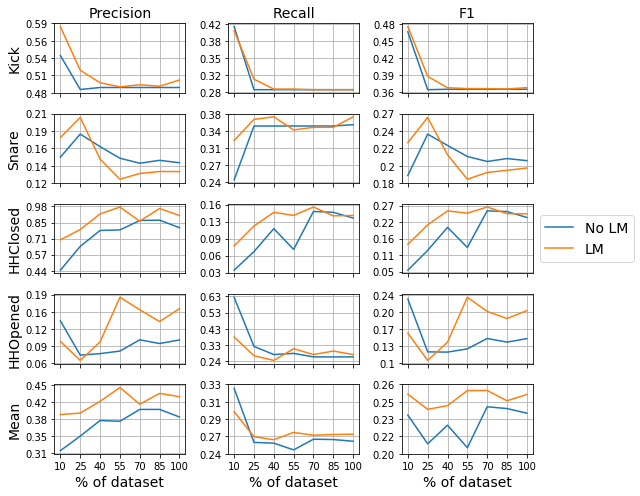

In [115]:
eval_series_p_nolm = vxs.metrics_series(evaluation_cfs_p, 'nolm')
eval_series_p_lm = vxs.metrics_series(evaluation_cfs_p, 'lm')
plot_all_metrics(eval_series_p_lm, eval_series_p_nolm, save_name='lm_nolm_avppersonal_gen')

In [49]:
evaluation_cfs_p_noonsets = vxs.evaluate_with_different_data_sizes(
    avp_segments_personal_p6_28, gen_set_p, lang_model,
    model_fn=lambda: vxs.make_knn_classic('mfcc', n_neighbors=15, weights='distance'),
    savedir_pattern='../logs/lm_eval/comparison_lm_mfcc_avppersonal_noonsets_p{}',
    predefined_bpm=True, predefined_onsets=True)

10% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.25it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:08,  5.67it/s]


prec       rec        F1
hhc  0.863905  0.128295  0.223412
hho  0.166185  0.815603   0.27611
kd   0.544425  0.733568     0.625
sd   0.328542  0.438356  0.375587

prec    0.475764
rec     0.528956
F1      0.375027
dtype: float64

Analysing tracks: 1it [00:00,  7.83it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.45it/s]


prec       rec        F1
hhc  0.814433   0.13884  0.237237
hho  0.122172  0.574468  0.201493
kd   0.549236   0.75939  0.637438
sd   0.281996  0.356164   0.31477

prec    0.441959
rec     0.457216
F1      0.347735
dtype: float64

25% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.12it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.38it/s]


prec       rec        F1
hhc  0.780822  0.100176   0.17757
hho  0.149929  0.751773      0.25
kd   0.524194  0.610329  0.563991
sd   0.245776  0.438356  0.314961

prec    0.425180
rec     0.475158
F1      0.326631
dtype: float64

Analysing tracks: 1it [00:00,  7.20it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.38it/s]


prec       rec        F1
hhc  0.698492  0.122144  0.207928
hho  0.140299  0.666667  0.231813
kd   0.526157   0.61385  0.566631
sd   0.240126  0.416438  0.304609

prec    0.401269
rec     0.454775
F1      0.327745
dtype: float64

40% of dataset
Classifier training...


Analysing tracks: 0it [00:00, ?it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.28it/s]


prec       rec        F1
hhc  0.919847   0.42355  0.580024
hho  0.191571   0.70922  0.301659
kd   0.698925  0.610329  0.651629
sd   0.226629  0.438356  0.298786

prec    0.509243
rec     0.545364
F1      0.458025
dtype: float64

Analysing tracks: 0it [00:00, ?it/s]

Evaluating (LM)


Analysing tracks: 50it [00:08,  5.61it/s]


prec       rec        F1
hhc  0.914339  0.431459  0.586269
hho  0.129344  0.475177  0.203338
kd    0.69496  0.615023  0.652553
sd   0.229985  0.432877   0.30038

prec    0.492157
rec     0.488634
F1      0.435635
dtype: float64

55% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.28it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.56it/s]


prec       rec        F1
hhc  0.954819  0.278559  0.431293
hho  0.120385  0.531915  0.196335
kd   0.698925  0.610329  0.651629
sd   0.200753  0.438356  0.275387

prec    0.493721
rec     0.464790
F1      0.388661
dtype: float64

Analysing tracks: 1it [00:00,  7.27it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.46it/s]


prec       rec        F1
hhc  0.929782  0.337434  0.495164
hho   0.11442   0.51773   0.18742
kd   0.705962  0.611502  0.655346
sd   0.224894  0.435616  0.296642

prec    0.493765
rec     0.475571
F1      0.408643
dtype: float64

70% of dataset
Classifier training...


Analysing tracks: 0it [00:00, ?it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.43it/s]


prec       rec        F1
hhc  0.863014  0.221441  0.352448
hho  0.152263  0.524823  0.236045
kd   0.698925  0.610329  0.651629
sd   0.164271  0.438356  0.238984

prec    0.469618
rec     0.448737
F1      0.369776
dtype: float64

Analysing tracks: 1it [00:00,  7.53it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.46it/s]


prec       rec        F1
hhc  0.900344  0.230228   0.36669
hho  0.138783   0.51773  0.218891
kd   0.703654  0.610329  0.653677
sd   0.169149  0.435616  0.243678

prec    0.477982
rec     0.448476
F1      0.370734
dtype: float64

85% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.08it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.30it/s]


prec       rec        F1
hhc  0.883162  0.225835  0.359692
hho  0.155602  0.531915   0.24077
kd   0.698925  0.610329  0.651629
sd   0.163432  0.438356  0.238095

prec    0.475280
rec     0.451609
F1      0.372547
dtype: float64

Analysing tracks: 1it [00:00,  8.06it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.48it/s]


prec       rec        F1
hhc  0.891156  0.230228  0.365922
hho  0.147117  0.524823  0.229814
kd   0.701754  0.610329  0.652856
sd   0.165971  0.435616  0.240363

prec    0.476500
rec     0.450249
F1      0.372239
dtype: float64

100% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.28it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.23it/s]


prec       rec        F1
hhc  0.872951   0.18717  0.308249
hho  0.142586  0.531915  0.224888
kd   0.698925  0.610329  0.651629
sd   0.162933  0.438356  0.237565

prec    0.469348
rec     0.441943
F1      0.355583
dtype: float64

Analysing tracks: 1it [00:00,  7.16it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.34it/s]


prec       rec        F1
hhc  0.878327  0.202988  0.329764
hho  0.141762  0.524823  0.223228
kd   0.700809  0.610329  0.652447
sd   0.164087  0.435616  0.238381

prec    0.471246
rec     0.443439
F1      0.360955
dtype: float64

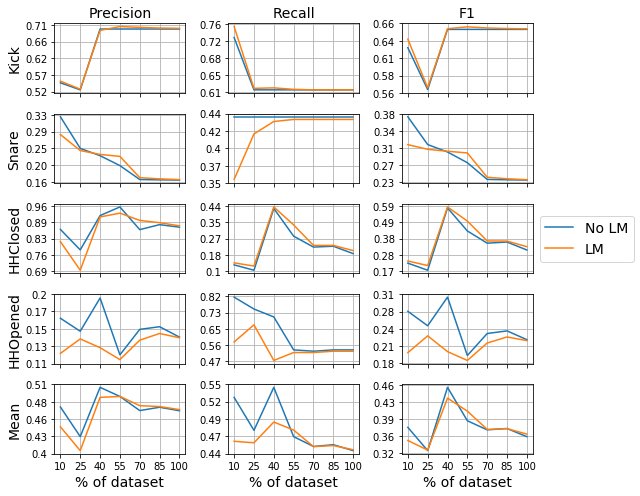

In [116]:
eval_series_p_noonsets_nolm = vxs.metrics_series(evaluation_cfs_p_noonsets, 'nolm')
eval_series_p_noonsets_lm = vxs.metrics_series(evaluation_cfs_p_noonsets, 'lm')
plot_all_metrics(eval_series_p_noonsets_lm, eval_series_p_noonsets_nolm, save_name='lm_nolm_avppersonal_gen_noonsets')

## Professional beatboxers: classifying only with real drum machine sounds

In [51]:
drums200 = vxs.SimpleSampleSet.from_csv('../data/200-drum-machines/annotation.csv')
print(len(drums200))
bbx1_gen = vxs.GenTrackSet('../data_temp/beatboxset1-gen')
print(len(bbx1_gen))

1422
50


In [52]:
evaluation_cfs_bbx1 = vxs.evaluate_with_different_data_sizes(
    drums200, bbx1_gen, lang_model,
    model_fn=lambda: vxs.make_knn_classic('mfcc', n_neighbors=15, weights='distance'),
    savedir_pattern='../logs/lm_eval/comparison_lm_mfcc_bbx1gen_p{}',
    predefined_bpm=True)

10% of dataset
Classifier training...


Analysing tracks: 0it [00:00, ?it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:10,  4.57it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.317718  0.940934  0.475035
sd    0.73747   0.66167  0.697517

prec    0.263797
rec     0.400651
F1      0.293138
dtype: float64

Analysing tracks: 1it [00:00,  7.71it/s]

Evaluating (LM)


Analysing tracks: 50it [00:08,  5.80it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.301065  0.892857  0.450294
sd   0.751899  0.635974  0.689095

prec    0.263241
rec     0.382208
F1      0.284847
dtype: float64

25% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.34it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:08,  5.71it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.370166   0.92033  0.527975
sd   0.410458  0.672377   0.50974

prec    0.195156
rec     0.398177
F1      0.259429
dtype: float64

Analysing tracks: 1it [00:00,  8.32it/s]

Evaluating (LM)


Analysing tracks: 50it [00:08,  5.79it/s]


prec         rec          F1
hhc         1  0.00167364  0.00334169
hho         0           0           0
kd   0.355033    0.891484    0.507825
sd   0.425414    0.659529    0.517212

prec    0.445112
rec     0.388172
F1      0.257095
dtype: float64

40% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.11it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.49it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.335903  0.837912   0.47956
sd   0.412385  0.670236  0.510604

prec    0.187072
rec     0.377037
F1      0.247541
dtype: float64

Analysing tracks: 0it [00:00, ?it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.33it/s]


prec         rec          F1
hhc         1  0.00083682  0.00167224
hho         0           0           0
kd   0.344699    0.888736    0.496737
sd   0.465976    0.674518    0.551181

prec    0.452669
rec     0.391023
F1      0.262398
dtype: float64

55% of dataset
Classifier training...


Analysing tracks: 0it [00:00, ?it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.30it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.357835  0.862637   0.50584
sd   0.382927  0.672377  0.487956

prec    0.185190
rec     0.383754
F1      0.248449
dtype: float64

Analysing tracks: 1it [00:00,  7.70it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.42it/s]


prec         rec          F1
hhc         1  0.00167364  0.00334169
hho         0           0           0
kd   0.352454    0.877747    0.502952
sd   0.410014    0.648822    0.502488

prec    0.440617
rec     0.382061
F1      0.252195
dtype: float64

70% of dataset
Classifier training...


Analysing tracks: 0it [00:00, ?it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.35it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.341094  0.865385   0.48932
sd   0.431319  0.672377  0.525523

prec    0.193103
rec     0.384440
F1      0.253711
dtype: float64

Analysing tracks: 1it [00:00,  7.60it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.33it/s]


prec         rec          F1
hhc         1  0.00167364  0.00334169
hho         0           0           0
kd   0.341164    0.877747    0.491349
sd   0.440353    0.640257    0.521815

prec    0.445379
rec     0.379919
F1      0.254127
dtype: float64

85% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.18it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.25it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd    0.33988  0.855769  0.486529
sd   0.419137  0.665953  0.514475

prec    0.189754
rec     0.380431
F1      0.250251
dtype: float64

Analysing tracks: 0it [00:00, ?it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.15it/s]


prec         rec          F1
hhc         1  0.00083682  0.00167224
hho         0           0           0
kd   0.352681    0.876374    0.502956
sd   0.408602    0.650964    0.502064

prec    0.440321
rec     0.382044
F1      0.251673
dtype: float64

100% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.22it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.20it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.341793  0.869505  0.490698
sd    0.42462  0.657388  0.515966

prec    0.191603
rec     0.381723
F1      0.251666
dtype: float64

Analysing tracks: 1it [00:00,  6.81it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.35it/s]


prec         rec          F1
hhc         1  0.00083682  0.00167224
hho         0           0           0
kd   0.344828    0.892857    0.497512
sd   0.450599     0.64454    0.530396

prec    0.448857
rec     0.384558
F1      0.257395
dtype: float64

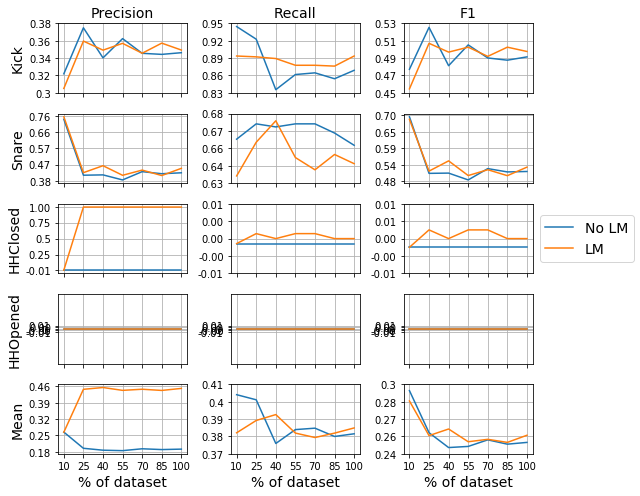

In [110]:
eval_series_bbx1_nolm = vxs.metrics_series(evaluation_cfs_bbx1, 'nolm')
eval_series_bbx1_lm = vxs.metrics_series(evaluation_cfs_bbx1, 'lm')
plot_all_metrics(eval_series_bbx1_lm, eval_series_bbx1_nolm)

In [54]:
evaluation_cfs_bbx1_noonsets = vxs.evaluate_with_different_data_sizes(
    drums200, bbx1_gen, lang_model,
    model_fn=lambda: vxs.make_knn_classic('mfcc', n_neighbors=15, weights='distance'),
    savedir_pattern='../logs/lm_eval/comparison_lm_mfcc_bbx1gen_noonsets_p{}',
    predefined_bpm=True, predefined_onsets=True)

10% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.08it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.44it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.397814         1  0.569195
sd   0.480597  0.689507  0.566403

prec    0.219603
rec     0.422377
F1      0.283899
dtype: float64

Analysing tracks: 1it [00:00,  8.42it/s]

Evaluating (LM)


Analysing tracks: 50it [00:08,  5.61it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.362031  0.901099  0.516535
sd   0.415698   0.61242  0.495238

prec    0.194432
rec     0.378380
F1      0.252943
dtype: float64

25% of dataset
Classifier training...


Analysing tracks: 0it [00:00, ?it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.37it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.405688  0.960165  0.570379
sd   0.378378   0.62955  0.472669

prec    0.196017
rec     0.397429
F1      0.260762
dtype: float64

Analysing tracks: 1it [00:00,  7.10it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.51it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.381473  0.910714  0.537713
sd   0.388451  0.633833  0.481692

prec    0.192481
rec     0.386137
F1      0.254851
dtype: float64

40% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.22it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.53it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.370857  0.891484   0.52381
sd      0.392   0.62955  0.483155

prec    0.190714
rec     0.380258
F1      0.251741
dtype: float64

Analysing tracks: 1it [00:00,  7.14it/s]

Evaluating (LM)


Analysing tracks: 50it [00:08,  5.58it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.371396  0.902473  0.526231
sd   0.409029  0.640257  0.499165

prec    0.195106
rec     0.385682
F1      0.256349
dtype: float64

55% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.15it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.42it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.387001  0.891484  0.539709
sd    0.35723   0.62955  0.455814

prec    0.186058
rec     0.380258
F1      0.248881
dtype: float64

Analysing tracks: 1it [00:00,  6.97it/s]

Evaluating (LM)


Analysing tracks: 50it [00:08,  5.58it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.378063   0.89011  0.530713
sd   0.368957  0.620985  0.462889

prec    0.186755
rec     0.377774
F1      0.248400
dtype: float64

70% of dataset
Classifier training...


Analysing tracks: 0it [00:00, ?it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.31it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.373418  0.891484  0.526358
sd   0.410761  0.670236  0.509357

prec    0.196045
rec     0.390430
F1      0.258929
dtype: float64

Analysing tracks: 1it [00:00,  7.29it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.51it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.371221  0.910714  0.527446
sd   0.403361  0.616702  0.487722

prec    0.193645
rec     0.381854
F1      0.253792
dtype: float64

85% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.15it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.31it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.370434  0.891484  0.523387
sd   0.393048   0.62955  0.483951

prec    0.190870
rec     0.380258
F1      0.251834
dtype: float64

Analysing tracks: 1it [00:00,  7.08it/s]

Evaluating (LM)


Analysing tracks: 50it [00:08,  5.59it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.379754  0.891484  0.532622
sd   0.370417  0.627409  0.465819

prec    0.187543
rec     0.379723
F1      0.249610
dtype: float64

100% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.09it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.43it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.371023  0.896978   0.52492
sd   0.397297   0.62955  0.487158

prec    0.192080
rec     0.381632
F1      0.253019
dtype: float64

Analysing tracks: 1it [00:00,  7.23it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.48it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.374068  0.895604  0.527722
sd   0.380449  0.616702  0.470588

prec    0.188629
rec     0.378077
F1      0.249577
dtype: float64

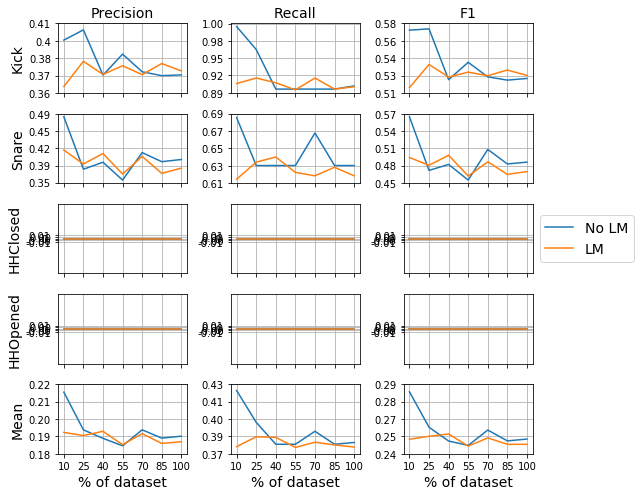

In [111]:
eval_series_bbx1_noonsets_nolm = vxs.metrics_series(evaluation_cfs_bbx1_noonsets, 'nolm')
eval_series_bbx1_noonsets_lm = vxs.metrics_series(evaluation_cfs_bbx1_noonsets, 'lm')
plot_all_metrics(eval_series_bbx1_noonsets_lm, eval_series_bbx1_noonsets_nolm)

### Real data: classifying AVP dataset (fixed)

In [56]:
avp_improv_fixed = vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset/', subset='Fixed', recordings_type='improvs')
len(avp_improv_fixed)

28

In [57]:
avp_hits_fixed = vxs.SimpleSampleSet(glob.glob('../data_temp/avp-cut/fixed/*/*.wav'))
len(avp_hits_fixed)

3316

In [58]:
evaluation_cfs_avpfixed_real = vxs.evaluate_with_different_data_sizes(
    avp_hits_fixed, avp_improv_fixed, lang_model,
    model_fn=lambda: vxs.make_knn_classic('mfcc', n_neighbors=15, weights='distance'),
    savedir_pattern='../logs/lm_eval/comparison_lm_mfcc_avpfixed_real_p{}')

10% of dataset
Classifier training...


Analysing tracks: 0it [00:00, ?it/s]

Evaluating (no LM)


Analysing tracks: 28it [00:03,  7.89it/s]


prec       rec        F1
hhc  0.656442  0.694805  0.675079
hho  0.775068  0.781421  0.778231
kd   0.817717  0.879121  0.847308
sd   0.737705  0.739726  0.738714

prec    0.746733
rec     0.773768
F1      0.759833
dtype: float64

Analysing tracks: 3it [00:00, 25.11it/s]

Evaluating (LM)


Analysing tracks: 28it [00:00, 30.01it/s]


prec       rec        F1
hhc  0.537084  0.681818  0.600858
hho  0.754325  0.595628  0.665649
kd    0.77371  0.851648  0.810811
sd   0.742515  0.679452  0.709585

prec    0.701909
rec     0.702137
F1      0.696726
dtype: float64

25% of dataset
Classifier training...


Analysing tracks: 2it [00:00, 14.01it/s]

Evaluating (no LM)


Analysing tracks: 28it [00:00, 28.81it/s]


prec       rec        F1
hhc    0.6275  0.814935   0.70904
hho  0.893082  0.775956  0.830409
kd   0.880952  0.880952  0.880952
sd    0.84375  0.887671  0.865154

prec    0.811321
rec     0.839879
F1      0.821389
dtype: float64

Analysing tracks: 3it [00:00, 25.04it/s]

Evaluating (LM)


Analysing tracks: 28it [00:00, 30.97it/s]


prec       rec        F1
hhc  0.561521  0.814935  0.664901
hho  0.871094   0.60929  0.717042
kd   0.813589  0.855311  0.833929
sd   0.840237  0.778082  0.807966

prec    0.771610
rec     0.764405
F1      0.755959
dtype: float64

40% of dataset
Classifier training...


Analysing tracks: 2it [00:00, 14.42it/s]

Evaluating (no LM)


Analysing tracks: 28it [00:00, 29.43it/s]


prec       rec        F1
hhc    0.6275  0.814935   0.70904
hho  0.885449  0.781421  0.830189
kd    0.89777  0.884615  0.891144
sd   0.847545   0.89863   0.87234

prec    0.814566
rec     0.844900
F1      0.825678
dtype: float64

Analysing tracks: 3it [00:00, 24.34it/s]

Evaluating (LM)


Analysing tracks: 28it [00:00, 30.87it/s]


prec       rec        F1
hhc  0.611511  0.827922  0.703448
hho   0.89011  0.663934  0.760563
kd   0.822917  0.868132   0.84492
sd   0.842407  0.805479  0.823529

prec    0.791736
rec     0.791367
F1      0.783115
dtype: float64

55% of dataset
Classifier training...


Analysing tracks: 2it [00:00, 14.75it/s]

Evaluating (no LM)


Analysing tracks: 28it [00:00, 28.16it/s]


prec       rec        F1
hhc  0.637056  0.814935    0.7151
hho  0.879257  0.775956  0.824383
kd   0.889925  0.873626  0.881701
sd   0.837975  0.906849  0.871053

prec    0.811053
rec     0.842842
F1      0.823059
dtype: float64

Analysing tracks: 3it [00:00, 23.45it/s]

Evaluating (LM)


Analysing tracks: 28it [00:01, 25.92it/s]


prec       rec        F1
hhc  0.593968  0.831169  0.692828
hho  0.908046  0.647541  0.755981
kd    0.86055  0.858974  0.859762
sd   0.820106  0.849315  0.834455

prec    0.795667
rec     0.796750
F1      0.785756
dtype: float64

70% of dataset
Classifier training...


Analysing tracks: 2it [00:00, 14.24it/s]

Evaluating (no LM)


Analysing tracks: 28it [00:01, 27.96it/s]


prec       rec        F1
hhc  0.641558  0.801948  0.712843
hho  0.876161  0.773224   0.82148
kd   0.876364  0.882784  0.879562
sd   0.848718  0.906849  0.876821

prec    0.810700
rec     0.841201
F1      0.822677
dtype: float64

Analysing tracks: 1it [00:00,  7.85it/s]

Evaluating (LM)


Analysing tracks: 28it [00:01, 27.64it/s]


prec       rec        F1
hhc  0.579909  0.824675  0.680965
hho  0.901235  0.598361  0.719212
kd    0.83452  0.858974   0.84657
sd   0.833333  0.849315  0.841248

prec    0.787249
rec     0.782831
F1      0.771999
dtype: float64

85% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  6.68it/s]

Evaluating (no LM)


Analysing tracks: 28it [00:01, 23.80it/s]


prec       rec        F1
hhc  0.640103  0.808442  0.714491
hho  0.853293  0.778689  0.814286
kd   0.896422  0.871795  0.883937
sd   0.840102  0.906849    0.8722

prec    0.807480
rec     0.841444
F1      0.821228
dtype: float64

Analysing tracks: 2it [00:00, 18.90it/s]

Evaluating (LM)


Analysing tracks: 28it [00:00, 29.31it/s]


prec       rec        F1
hhc  0.584906  0.805195  0.677596
hho  0.869231  0.617486  0.722045
kd   0.844732  0.836996  0.840846
sd   0.805128  0.860274  0.831788

prec    0.775999
rec     0.779988
F1      0.768069
dtype: float64

100% of dataset
Classifier training...


Analysing tracks: 2it [00:00, 12.53it/s]

Evaluating (no LM)


Analysing tracks: 28it [00:01, 27.05it/s]


prec       rec        F1
hhc  0.642857  0.818182      0.72
hho  0.859327   0.76776  0.810967
kd   0.887661  0.882784  0.885216
sd   0.857513  0.906849  0.881491

prec    0.811840
rec     0.843894
F1      0.824418
dtype: float64

Analysing tracks: 3it [00:00, 24.43it/s]

Evaluating (LM)


Analysing tracks: 28it [00:00, 29.05it/s]


prec       rec        F1
hhc  0.589327  0.824675  0.687415
hho     0.884  0.603825  0.717532
kd   0.871324  0.868132  0.869725
sd   0.846154   0.90411  0.874172

prec    0.797701
rec     0.800185
F1      0.787211
dtype: float64

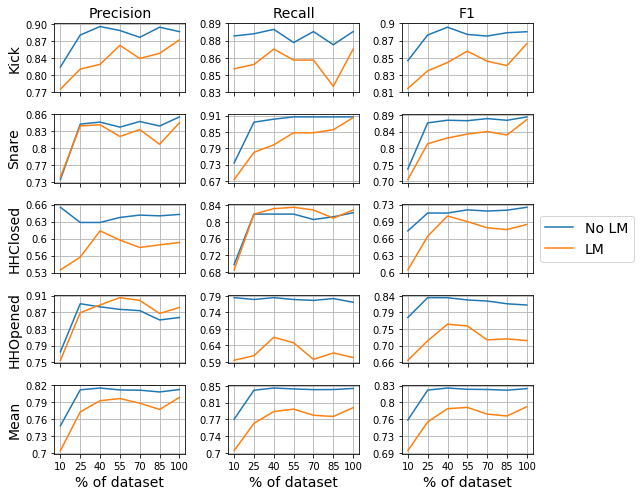

In [117]:
eval_series_avpfixed_real_nolm = vxs.metrics_series(evaluation_cfs_avpfixed_real, 'nolm')
eval_series_avpfixed_real_lm = vxs.metrics_series(evaluation_cfs_avpfixed_real, 'lm')
plot_all_metrics(eval_series_avpfixed_real_lm, eval_series_avpfixed_real_nolm, save_name='lm_nolm_avpfixed_real')

### Real data: AVP Personal

In [60]:
avp_improv_personal = vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset/', subset='Personal', recordings_type='improvs')
len(avp_improv_personal)

25

In [61]:
avp_hits_personal = vxs.SimpleSampleSet(glob.glob('../data_temp/avp-cut/personal/*/*.wav'))
len(avp_hits_personal)

2875

In [62]:
evaluation_cfs_avppersonal_real = vxs.evaluate_with_different_data_sizes(
    avp_hits_personal, avp_improv_personal, lang_model,
    model_fn=lambda: vxs.make_knn_classic('mfcc', n_neighbors=15, weights='distance'),
    savedir_pattern='../logs/lm_eval/comparison_lm_mfcc_avppersonal_real_p{}')

10% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.40it/s]

Evaluating (no LM)


Analysing tracks: 25it [00:02,  8.49it/s]


prec       rec        F1
hhc  0.409449  0.482972  0.443182
hho  0.296178  0.537572   0.38193
kd   0.712977  0.829485  0.766831
sd   0.607287   0.40107  0.483092

prec    0.506473
rec     0.562775
F1      0.518759
dtype: float64

Analysing tracks: 2it [00:00, 19.46it/s]

Evaluating (LM)


Analysing tracks: 25it [00:00, 29.72it/s]


prec       rec        F1
hhc  0.378072  0.619195  0.469484
hho   0.27673  0.254335   0.26506
kd    0.67285  0.708703  0.690311
sd   0.546816  0.390374  0.455538

prec    0.468617
rec     0.493152
F1      0.470098
dtype: float64

25% of dataset
Classifier training...


Analysing tracks: 2it [00:00, 11.85it/s]

Evaluating (no LM)


Analysing tracks: 25it [00:00, 28.51it/s]


prec       rec        F1
hhc  0.466146   0.55418  0.506365
hho  0.340659  0.537572   0.41704
kd   0.727829  0.845471  0.782251
sd   0.615385  0.470588  0.533333

prec    0.537505
rec     0.601953
F1      0.559748
dtype: float64

Analysing tracks: 3it [00:00, 22.54it/s]

Evaluating (LM)


Analysing tracks: 25it [00:00, 32.48it/s]


prec       rec        F1
hhc  0.405941  0.634675  0.495169
hho  0.397059  0.312139  0.349515
kd   0.699664  0.740675  0.719586
sd   0.572347  0.475936  0.519708

prec    0.518753
rec     0.540856
F1      0.520994
dtype: float64

40% of dataset
Classifier training...


Analysing tracks: 2it [00:00, 11.57it/s]

Evaluating (no LM)


Analysing tracks: 25it [00:00, 27.93it/s]


prec       rec        F1
hhc  0.494083  0.517028  0.505295
hho   0.34767  0.560694  0.429204
kd    0.71137  0.866785  0.781425
sd   0.670068  0.526738   0.58982

prec    0.555798
rec     0.617811
F1      0.576436
dtype: float64

Analysing tracks: 1it [00:00,  6.40it/s]

Evaluating (LM)


Analysing tracks: 25it [00:00, 26.94it/s]


prec       rec        F1
hhc  0.466507  0.603715  0.526316
hho  0.293478  0.312139  0.302521
kd   0.673945   0.82238    0.7408
sd   0.621622  0.430481  0.508689

prec    0.513888
rec     0.542179
F1      0.519581
dtype: float64

55% of dataset
Classifier training...


Analysing tracks: 2it [00:00, 11.31it/s]

Evaluating (no LM)


Analysing tracks: 25it [00:00, 26.19it/s]


prec       rec        F1
hhc  0.526946  0.544892  0.535769
hho  0.338182  0.537572  0.415179
kd   0.703808  0.886323  0.784591
sd   0.698925   0.52139  0.597243

prec    0.566965
rec     0.622544
F1      0.583195
dtype: float64

Analysing tracks: 1it [00:00,  6.23it/s]

Evaluating (LM)


Analysing tracks: 25it [00:00, 25.26it/s]


prec       rec        F1
hhc  0.532258  0.613003  0.569784
hho  0.350877  0.462428  0.399002
kd   0.675637  0.847247  0.751773
sd   0.752066  0.486631  0.590909

prec    0.577710
rec     0.602327
F1      0.577867
dtype: float64

70% of dataset
Classifier training...


Analysing tracks: 2it [00:00, 12.04it/s]

Evaluating (no LM)


Analysing tracks: 25it [00:01, 24.43it/s]


prec       rec        F1
hhc  0.534535  0.551084  0.542683
hho  0.320755  0.491329  0.388128
kd   0.702098  0.891652  0.785603
sd   0.676056  0.513369  0.583587

prec    0.558361
rec     0.611858
F1      0.575000
dtype: float64

Analysing tracks: 2it [00:00, 19.08it/s]

Evaluating (LM)


Analysing tracks: 25it [00:00, 30.50it/s]


prec       rec        F1
hhc  0.544959  0.619195   0.57971
hho  0.346939  0.393064  0.368564
kd    0.67507  0.856128  0.754894
sd   0.715867  0.518717   0.60155

prec    0.570709
rec     0.596776
F1      0.576180
dtype: float64

85% of dataset
Classifier training...


Analysing tracks: 2it [00:00, 11.98it/s]

Evaluating (no LM)


Analysing tracks: 25it [00:01, 24.39it/s]


prec       rec        F1
hhc  0.524242  0.535604  0.529862
hho  0.332117  0.526012  0.407159
kd        0.7  0.882771  0.780833
sd    0.70318  0.532086  0.605784

prec    0.564885
rec     0.619118
F1      0.580909
dtype: float64

Analysing tracks: 2it [00:00, 17.34it/s]

Evaluating (LM)


Analysing tracks: 25it [00:00, 27.88it/s]


prec       rec        F1
hhc  0.548556  0.647059   0.59375
hho  0.360215  0.387283  0.373259
kd   0.670851  0.854352  0.751563
sd       0.75  0.529412   0.62069

prec    0.582406
rec     0.604526
F1      0.584815
dtype: float64

100% of dataset
Classifier training...


Analysing tracks: 0it [00:00, ?it/s]

Evaluating (no LM)


Analysing tracks: 25it [00:01, 21.67it/s]


prec       rec        F1
hhc  0.515432  0.517028  0.516229
hho  0.311594   0.49711  0.383073
kd   0.700141  0.879218  0.779528
sd   0.686207  0.532086  0.599398

prec    0.553344
rec     0.606360
F1      0.569557
dtype: float64

Analysing tracks: 2it [00:00, 10.67it/s]

Evaluating (LM)


Analysing tracks: 25it [00:00, 25.32it/s]


prec       rec        F1
hhc  0.559322  0.613003  0.584934
hho  0.330049  0.387283  0.356383
kd    0.67972  0.863233  0.760563
sd   0.721014  0.532086  0.612308

prec    0.572527
rec     0.598901
F1      0.578547
dtype: float64

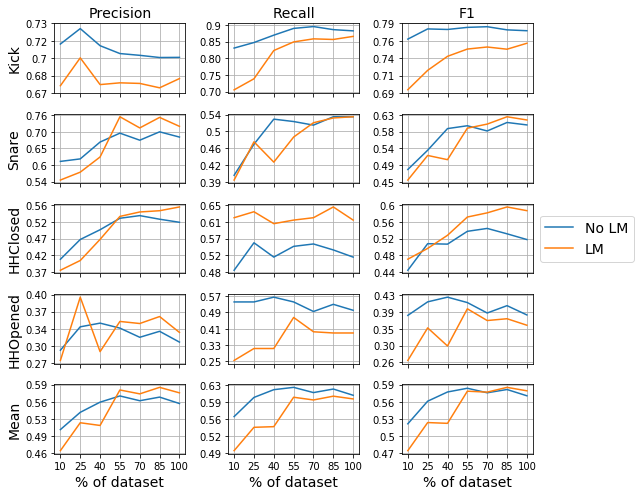

In [118]:
eval_series_avppersonal_real_nolm = vxs.metrics_series(evaluation_cfs_avppersonal_real, 'nolm')
eval_series_avppersonal_real_lm = vxs.metrics_series(evaluation_cfs_avppersonal_real, 'lm')
plot_all_metrics(eval_series_avppersonal_real_lm, eval_series_avppersonal_real_nolm, save_name='lm_nolm_avppersonal_real')

### Sanity check: using ground-truth onsets

In [104]:
trueonsets_mfcc_cf, trueonsets_mfcc_scores = vxs.segment_classify_all(
    gen_set, model, predefined_bpm=True, predefined_onsets=True)

Analysing tracks: 50it [00:36,  1.35it/s]


In [105]:
trueonsets_mfcc_cf

hhc    hho     kd     sd  sil
hhc  334.0  619.0    0.0  100.0  0.0
hho   13.0  322.0    0.0    0.0  0.0
kd     0.0    0.0  754.0    0.0  0.0
sd     0.0   59.0   17.0  311.0  0.0
sil    0.0    0.0    0.0    0.0  0.0

In [106]:
trueonsets_mfcc_scores

prec       rec        F1
hhc  0.962536  0.317189  0.477143
hho     0.322  0.961194  0.482397
kd   0.977951         1  0.988852
sd   0.756691  0.803618  0.779449

In [107]:
trueonsets_mfcc_scores.mean()

prec    0.754794
rec     0.770500
F1      0.681960
dtype: float64

In [108]:
trueonsets_lang_cf, trueonsets_lang_scores = vxs.segment_classify_all(
    gen_set, model, lang_model, predefined_bpm=True, predefined_onsets=True, steps_per_iteration=4)

Analysing tracks: 1it [00:05,  5.53s/it]

Beam search yields sequence with likelihood -45.4416639881755


Analysing tracks: 2it [00:11,  5.81s/it]

Beam search yields sequence with likelihood -47.357199438158446


Analysing tracks: 3it [00:38, 12.17s/it]

Beam search yields sequence with likelihood -52.03451632466179


Analysing tracks: 4it [00:44, 10.03s/it]

Beam search yields sequence with likelihood -24.14751382903364


Analysing tracks: 5it [00:51,  9.34s/it]

Beam search yields sequence with likelihood -79.3662236852782


Analysing tracks: 6it [00:54,  7.31s/it]

Beam search yields sequence with likelihood -16.13511126544522


Analysing tracks: 7it [00:58,  6.45s/it]

Beam search yields sequence with likelihood -15.70681544375317


Analysing tracks: 8it [01:00,  5.14s/it]

Beam search yields sequence with likelihood -40.01983407030317


Analysing tracks: 9it [01:03,  4.50s/it]

Beam search yields sequence with likelihood -27.577476400559863


Analysing tracks: 10it [01:08,  4.65s/it]

Beam search yields sequence with likelihood -15.538816763252289


Analysing tracks: 11it [01:13,  4.77s/it]

Beam search yields sequence with likelihood -67.1138202016709


Analysing tracks: 12it [01:17,  4.55s/it]

Beam search yields sequence with likelihood -124.25836434207854


Analysing tracks: 13it [01:20,  3.85s/it]

Beam search yields sequence with likelihood -25.100291603640365


Analysing tracks: 14it [01:24,  3.95s/it]

Beam search yields sequence with likelihood -72.28952519287107


Analysing tracks: 15it [01:27,  3.77s/it]

Beam search yields sequence with likelihood -15.585866807777293


Analysing tracks: 16it [01:34,  4.73s/it]

Beam search yields sequence with likelihood -37.52016325533401


Analysing tracks: 17it [01:36,  4.00s/it]

Beam search yields sequence with likelihood -10.96184775453935


Analysing tracks: 18it [01:38,  3.36s/it]

Beam search yields sequence with likelihood -52.21449570244002


Analysing tracks: 19it [01:42,  3.45s/it]

Beam search yields sequence with likelihood -67.89047819959389


Analysing tracks: 20it [01:47,  3.81s/it]

Beam search yields sequence with likelihood -27.61270453848575


Analysing tracks: 21it [01:53,  4.47s/it]

Beam search yields sequence with likelihood -54.06167884404707


Analysing tracks: 22it [01:55,  3.78s/it]

Beam search yields sequence with likelihood -15.153838957200845


Analysing tracks: 23it [02:00,  4.20s/it]

Beam search yields sequence with likelihood -50.670115154444964


Analysing tracks: 24it [02:06,  4.75s/it]

Beam search yields sequence with likelihood -20.64763988467976


Analysing tracks: 25it [02:15,  5.96s/it]

Beam search yields sequence with likelihood -28.028582587410938


Analysing tracks: 26it [02:25,  7.16s/it]

Beam search yields sequence with likelihood -36.410354166467194


Analysing tracks: 27it [02:29,  6.21s/it]

Beam search yields sequence with likelihood -32.45039892337162


Analysing tracks: 28it [02:31,  4.90s/it]

Beam search yields sequence with likelihood -47.79683345614739


Analysing tracks: 29it [02:38,  5.68s/it]

Beam search yields sequence with likelihood -61.58667649719572


Analysing tracks: 30it [02:43,  5.40s/it]

Beam search yields sequence with likelihood -64.20625464527714


Analysing tracks: 31it [02:46,  4.77s/it]

Beam search yields sequence with likelihood -60.95637454862572


Analysing tracks: 32it [02:49,  4.07s/it]

Beam search yields sequence with likelihood -26.556070133284955


Analysing tracks: 33it [02:54,  4.37s/it]

Beam search yields sequence with likelihood -18.50473904645159


Analysing tracks: 34it [02:57,  4.08s/it]

Beam search yields sequence with likelihood -18.462064663188837


Analysing tracks: 35it [03:09,  6.30s/it]

Beam search yields sequence with likelihood -78.71159340928166


Analysing tracks: 36it [03:11,  5.20s/it]

Beam search yields sequence with likelihood -22.51996790053148


Analysing tracks: 37it [03:17,  5.36s/it]

Beam search yields sequence with likelihood -39.47197832226025


Analysing tracks: 38it [03:22,  5.15s/it]

Beam search yields sequence with likelihood -69.1784220950409


Analysing tracks: 39it [03:27,  5.13s/it]

Beam search yields sequence with likelihood -90.81624438227293


Analysing tracks: 40it [03:32,  5.06s/it]

Beam search yields sequence with likelihood -32.85198709743681


Analysing tracks: 41it [03:34,  4.18s/it]

Beam search yields sequence with likelihood -52.55948078621257


Analysing tracks: 42it [03:38,  4.34s/it]

Beam search yields sequence with likelihood -44.24442539037042


Analysing tracks: 43it [03:42,  4.03s/it]

Beam search yields sequence with likelihood -70.851773153763


Analysing tracks: 44it [03:45,  3.77s/it]

Beam search yields sequence with likelihood -114.00533063878311


Analysing tracks: 45it [03:48,  3.45s/it]

Beam search yields sequence with likelihood -40.80646706165996


Analysing tracks: 46it [03:53,  4.07s/it]

Beam search yields sequence with likelihood -38.166652965347055


Analysing tracks: 47it [03:57,  4.15s/it]

Beam search yields sequence with likelihood -36.81829271273873


Analysing tracks: 48it [04:00,  3.78s/it]

Beam search yields sequence with likelihood -48.57001962859093


Analysing tracks: 49it [04:07,  4.67s/it]

Beam search yields sequence with likelihood -38.42087031393548


Analysing tracks: 50it [04:12,  5.04s/it]

Beam search yields sequence with likelihood -56.6277324665557


In [109]:
trueonsets_lang_cf

hhc    hho     kd     sd  sil
hhc  380.0  569.0    8.0   96.0  0.0
hho   12.0  323.0    0.0    0.0  0.0
kd     0.0    0.0  744.0   10.0  0.0
sd     2.0   58.0   32.0  295.0  0.0
sil    0.0    0.0    0.0    0.0  0.0

In [110]:
trueonsets_lang_scores

prec       rec        F1
hhc  0.964467  0.360874  0.525225
hho      0.34  0.964179  0.502724
kd    0.94898  0.986737   0.96749
sd   0.735661  0.762274  0.748731

In [111]:
trueonsets_lang_scores.mean()

prec    0.747277
rec     0.768516
F1      0.686042
dtype: float64

In [27]:
cwide_cf, cwide_scores = vxs.segment_classify_all(gen_set, model_cae, predefined_bpm=True,
                                                  quantization_conflict_resolution=None)

Analysing tracks: 50it [01:16,  1.53s/it]


In [28]:
cwide_cf

hhc   hho     kd     sd    sil
hhc  367.0   0.0  113.0  472.0  101.0
hho  146.0  85.0    0.0  104.0    0.0
kd     0.0   0.0  421.0   22.0  311.0
sd    50.0   0.0  237.0   99.0    1.0
sil    8.0   0.0    8.0  151.0    0.0

In [40]:
cwide_cf.loc['hho', 'hhc']

146.0

In [29]:
cwide_scores

prec       rec        F1
hhc  0.348528  0.642732   0.45197
hho  0.253731         1  0.404762
kd   0.558355  0.540436   0.54925
sd   0.255814  0.116745  0.160324

In [30]:
cwide_scores.mean()

prec    0.354107
rec     0.574978
F1      0.391577
dtype: float64

In [31]:
lang_cw_cf, lang_cw_scores = vxs.segment_classify_all(gen_set, model_cae, lang_model, predefined_bpm=True,
                                                      steps_per_iteration=4, beam_size=5)

Analysing tracks: 0it [00:00, ?it/s]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -79.467619 


Analysing tracks: 1it [00:30, 30.23s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -92.954670 


Analysing tracks: 2it [00:36, 22.97s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -55.412680 


Analysing tracks: 3it [00:48, 19.75s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -38.034865 


Analysing tracks: 4it [00:52, 14.89s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -110.428432 


Analysing tracks: 5it [00:56, 11.82s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -40.534127 


Analysing tracks: 6it [00:59,  9.08s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -69.598919 


Analysing tracks: 7it [01:02,  7.44s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -48.961862 


Analysing tracks: 8it [01:06,  6.34s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -64.315867 


Analysing tracks: 9it [01:09,  5.36s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -34.227495 


Analysing tracks: 10it [01:11,  4.31s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -139.103029 


Analysing tracks: 11it [01:20,  5.70s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -129.145971 


Analysing tracks: 12it [01:25,  5.40s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -56.952572 


Analysing tracks: 13it [01:27,  4.39s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -96.760351 


Analysing tracks: 14it [01:31,  4.40s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -49.759155 


Analysing tracks: 15it [01:33,  3.64s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -78.774110 


Analysing tracks: 16it [01:53,  8.51s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -24.128610 


Analysing tracks: 17it [01:55,  6.39s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -72.078921 


Analysing tracks: 18it [01:57,  5.20s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -99.996665 


Analysing tracks: 19it [02:02,  5.23s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -36.340344 


Analysing tracks: 20it [02:06,  4.81s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -72.015766 


Analysing tracks: 21it [02:09,  4.30s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -42.342292 


Analysing tracks: 22it [02:11,  3.67s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -58.836558 


Analysing tracks: 23it [02:19,  4.91s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -71.787585 


Analysing tracks: 24it [02:24,  4.99s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -53.077088 


Analysing tracks: 25it [02:35,  6.67s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -62.115231 


Analysing tracks: 26it [02:38,  5.68s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -38.096362 


Analysing tracks: 27it [02:43,  5.29s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -64.972465 


Analysing tracks: 28it [02:45,  4.48s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -58.203970 


Analysing tracks: 29it [02:52,  5.04s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -79.563095 


Analysing tracks: 30it [02:59,  5.80s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -97.022107 


Analysing tracks: 31it [03:02,  4.97s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -68.924187 


Analysing tracks: 32it [03:06,  4.48s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -54.180359 


Analysing tracks: 33it [03:16,  6.28s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -36.515571 


Analysing tracks: 34it [03:18,  5.06s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -67.882079 


Analysing tracks: 35it [03:23,  4.83s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -26.888749 


Analysing tracks: 36it [03:25,  4.24s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -62.564333 


Analysing tracks: 37it [03:29,  4.02s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -80.499788 


Analysing tracks: 38it [03:32,  3.73s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -112.854177 


Analysing tracks: 39it [03:48,  7.39s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -46.363079 


Analysing tracks: 40it [03:50,  5.88s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -71.055798 


Analysing tracks: 41it [03:54,  5.10s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -72.473395 


Analysing tracks: 42it [03:57,  4.56s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -98.406987 


Analysing tracks: 43it [03:59,  3.88s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -101.510722 


Analysing tracks: 44it [04:04,  4.08s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -56.525251 


Analysing tracks: 45it [04:07,  3.72s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -68.054468 


Analysing tracks: 46it [04:12,  4.22s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -57.922741 


Analysing tracks: 47it [04:15,  3.83s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -61.715265 


Analysing tracks: 48it [04:17,  3.44s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -44.473912 


Analysing tracks: 49it [04:28,  5.59s/it]

INFO:tensorflow:Beam search yields sequence with log-likelihood: -56.881484 


Analysing tracks: 50it [04:38,  5.57s/it]


In [32]:
lang_cw_cf

hhc   hho     kd     sd    sil
hhc  420.0   0.0   85.0  442.0  106.0
hho  142.0  27.0   18.0  145.0    3.0
kd     2.0   0.0  355.0   83.0  314.0
sd    82.0   0.0  150.0  153.0    2.0
sil    4.0   0.0    8.0  148.0    0.0

In [33]:
lang_cw_scores

prec       rec        F1
hhc   0.39886  0.646154  0.493247
hho  0.080597         1  0.149171
kd   0.470822  0.576299  0.518248
sd   0.395349   0.15757  0.225331

In [34]:
lang_cw_scores.mean()

prec    0.336407
rec     0.595006
F1      0.346500
dtype: float64